<p style="margin: 0; text-align:right;">2022-1 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>


### Series temporales y combinación de modelos de clasificación

Está práctica está dividida en dos partes:

 - En el primer ejercicio veremos cómo descomponer y componer series temporales para realizar predicciones a futuro. 
 - En el segundo ejercicio estudiaremos diferentes técnicas mediante las que podremos combinar el resultado de múltiples clasificadores.


<div class="alert alert-block alert-info">
<strong>Nombre y apellidos: Eugenia Bezek</strong>
</div>

---

Para ello vamos a necesitar las siguientes librerías:

In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.stats
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, train_test_split, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline

### 1. Series temporales

En este primer ejercicio trabajaremos las series temporales. Para ello, usaremos el dataset *AirPassangers* que contiene información del número de vuelos que se realizaron a lo largo de muchos años.

Empezaremos leyendo los datos y observando gráficamente su distribución. Como se puede apreciar es un claro caso de serie temporal, con heterocedasticidad, tendencia, periodo y ruido. A lo largo de este ejercicio trataremos cada uno de estos puntos.

In [2]:
data = pd.read_csv('AirPassengers.csv', parse_dates=['Month'], index_col='Month', header=0)
data.head()

,Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


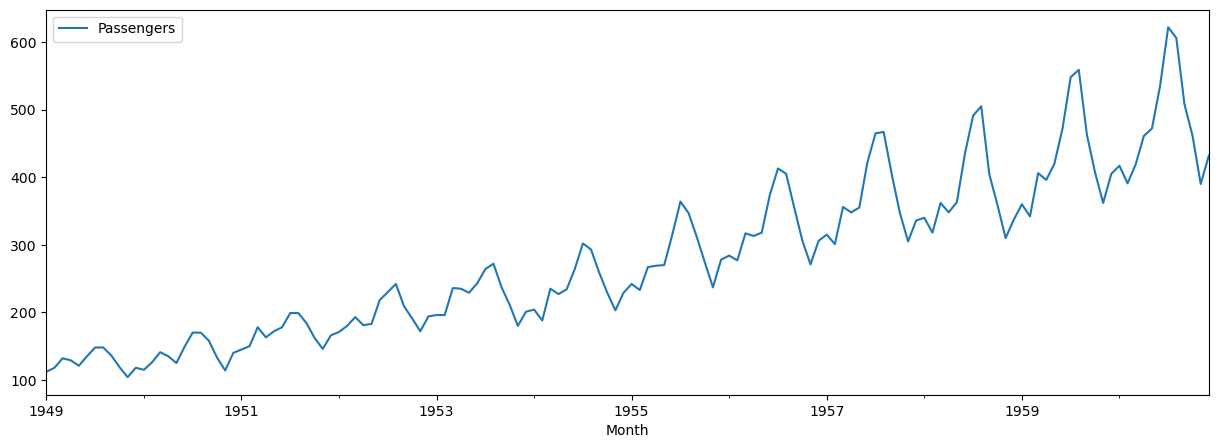

In [3]:
data.plot(figsize=(15, 5))
plt.show()

Antes de empezar a tratar las diferentes componenetes de una serie temporal, eliminaremos del dataset original un par de años de datos. Así cuando hagamos una predicción a futuro podremos comprobar si se ajusta a los datos reales.

In [4]:
TEST_SIZE = 24
train, test = data.iloc[:-TEST_SIZE].to_numpy(), data.iloc[-TEST_SIZE:].to_numpy()
x_train, x_test = np.arange(train.shape[0]), np.arange(train.shape[0], data.shape[0])
train.shape, x_train.shape, test.shape, x_test.shape

((120, 1), (120,), (24, 1), (24,))

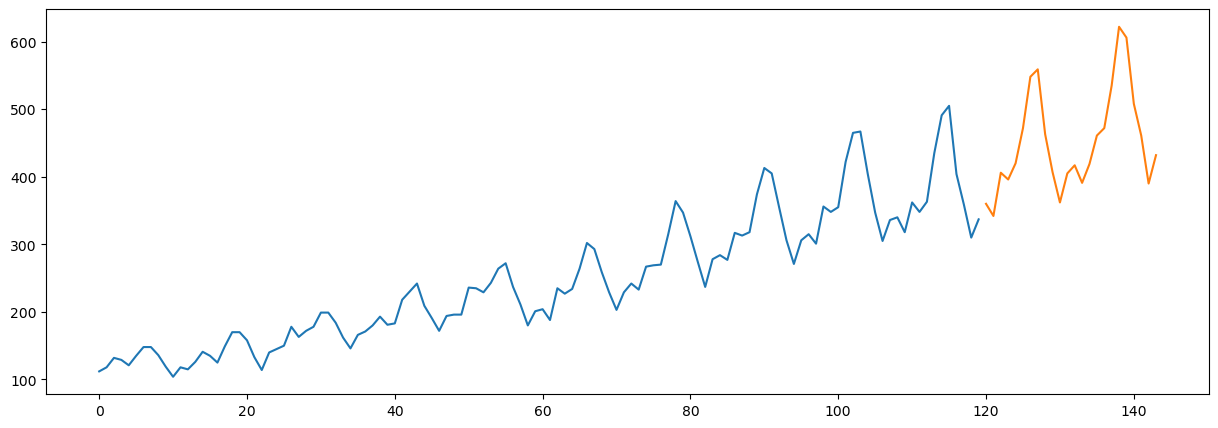

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 5))
ax.plot(x_train, train)
ax.plot(x_test, test)
plt.show()

### 1.1 Componentes de la serie temporal

### 1.1.a. Heterocedasticidad

Se dice que una serie temporal tiene heterocedasticidad cuando la variancia varía con el tiempo (https://es.wikipedia.org/wiki/Heterocedasticidad). En nuestro caso, observamos que tenemos heterocedasticidad, ya que la amplitud de onda varía con el tiempo. En este primer apartado debéis eliminar la heterocedasticidad de la serie temporal. Es decir, que la diferencia entre el mínimo y el máximo de la estacionalidad (anual) sea más o menos la misma a lo largo del tiempo.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> transforma los datos para eliminar la heterocedasticidad. Para ello debéis transformar los datos aplicando la función que consideréis que elimina mejor la heterocedasticidad en el dataset (exponencial, logarítmica, ...). Estas funciones ya están implementadas en numpy. Graficar los datos originales junto con los datos transformados.
</div>

In [6]:
#Agrego columnas de Month y de Year:
data.index.names = ['index']
data['Month'] = data.index.month
data['Year'] = data.index.year
data['Day'] = data.index.day
data.head()

,Passengers,Month,Year,Day
index,,,,
1949-01-01,112,1,1949,1
1949-02-01,118,2,1949,1
1949-03-01,132,3,1949,1
1949-04-01,129,4,1949,1
1949-05-01,121,5,1949,1


In [7]:
#Convierto el conjunto de train en un dataframe para manipularlo mas facil: 
column_values = ['Passengers', 'Month', 'Year', 'Day']
df = pd.DataFrame(data = data.iloc[:-TEST_SIZE], 
                  columns = column_values)

In [8]:
#Agrego una columna con la transformacion logaritmica:
df['Log Passengers'] = np.log(df['Passengers'])
df.head()

,Passengers,Month,Year,Day,Log Passengers
index,,,,,
1949-01-01,112,1,1949,1,4.718499
1949-02-01,118,2,1949,1,4.770685
1949-03-01,132,3,1949,1,4.882802
1949-04-01,129,4,1949,1,4.859812
1949-05-01,121,5,1949,1,4.795791


In [9]:
# Armo un dataset con el valor maximo y minimo de pasajeros por año: 
data_grouped = df[['Year','Passengers']].groupby('Year').min()
data_grouped.rename(columns = {'Passengers':'min_by_year'}, inplace = True)
data_grouped['max_by_year'] = df[['Year','Passengers']].groupby('Year').max()
data_grouped['diferencia'] = data_grouped['max_by_year'] - data_grouped['min_by_year']
data_grouped.head()

,min_by_year,max_by_year,diferencia
Year,,,
1949,104,148,44
1950,114,170,56
1951,145,199,54
1952,171,242,71
1953,180,272,92


In [10]:
#Ahora repito el procesimiento pero comparando el minimo y maximo de los datos transformados: 
data_grouped['log_max_by_year'] = df[['Year','Log Passengers']].groupby('Year').max()
data_grouped['log_min_by_year'] = df[['Year','Log Passengers']].groupby('Year').min()
data_grouped['log_diferencia'] = data_grouped['log_max_by_year'] - data_grouped['log_min_by_year']
data_grouped.head()

,min_by_year,max_by_year,diferencia,log_max_by_year,log_min_by_year,log_diferencia
Year,,,,,,
1949,104,148,44,4.997212,4.644391,0.352821
1950,114,170,56,5.135798,4.736198,0.399600
1951,145,199,54,5.293305,4.976734,0.316571
1952,171,242,71,5.488938,5.141664,0.347274
1953,180,272,92,5.605802,5.192957,0.412845


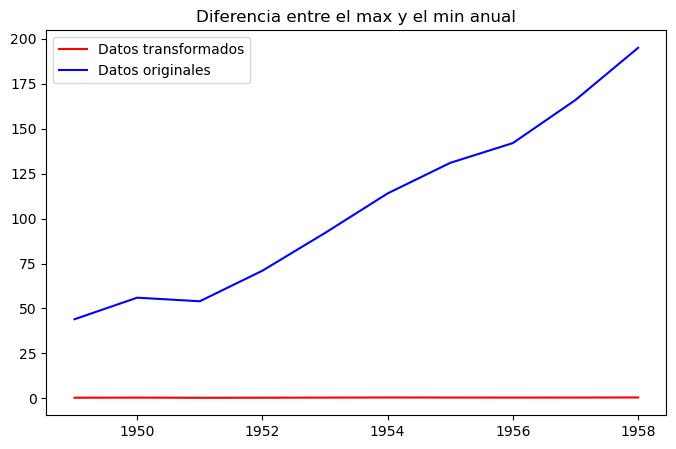

In [11]:
#Grafico:
plt.figure(figsize=(8,5))
plt.plot(data_grouped['log_diferencia'],'r')
plt.plot(data_grouped['diferencia'],'b')
plt.title('Diferencia entre el max y el min anual', fontsize = 12)
plt.legend(["Datos transformados", "Datos originales"])
plt.show()

Vemos que al aplicar la transformación logarítmica a los datos, la diferencia entre el mínimo y el máximo anual es la misma en todos los años. 

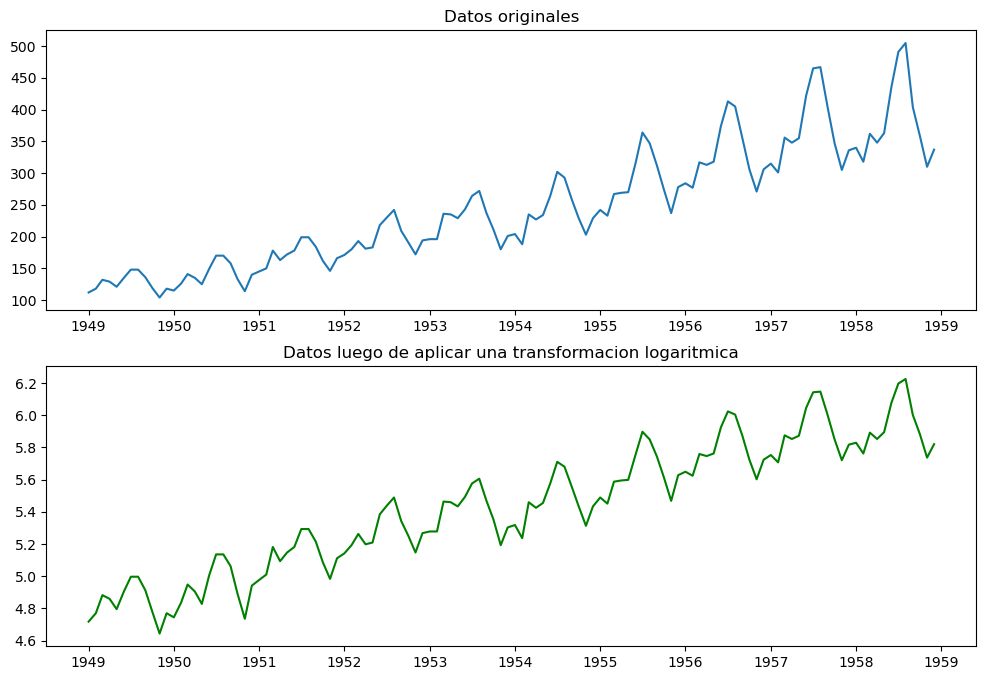

In [12]:
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.plot(df['Passengers'])
plt.title('Datos originales')
plt.subplot(2, 1, 2)
plt.plot(df['Log Passengers'], c = 'g')
plt.title('Datos luego de aplicar una transformacion logaritmica')
plt.show()

Vemos que con la transformación el maximo y minimo de cada "ciclo" es mucho más parejo que en la serie original

### 1.1.b. Tendencia

La tendencia es el comportamento que tienen los datos a largo plazo (https://miro.medium.com/max/1872/1*rDQL2fAp_X_dgAHNZuwRfw.png). En nuestra serie temporal tenemos una tendencia lineal creciente. En este apartado debéis eliminar la tendencia, quedando una serie temporal con tendencia constante.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> elimina la tendencia de los datos. Observando la serie podemos apreciar que tenemos una tendencia lineal, por ese motivo podemos ajustar una regresión lineal (usando scikit-learn) y sustraerla a los datos originales (sin heterocedasticidad). Graficar los datos con tendencia junto con los datos sin tendencia.
</div>

In [13]:
y = df['Log Passengers']
X = np.array(range(len(df['Log Passengers'])))

In [14]:
reg = LinearRegression().fit(X.reshape(-1,1), y)
pred_lin = reg.predict(X.reshape(-1,1))  

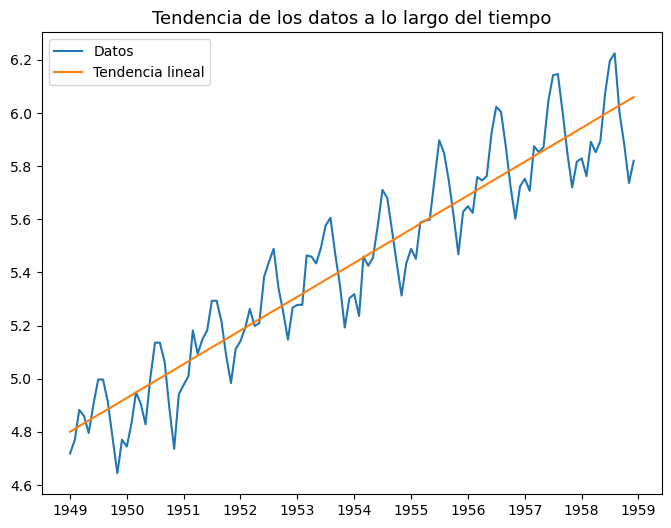

In [15]:
plt.figure(figsize=(8,6))
plt.plot(df['Log Passengers'], label="Datos")
plt.plot(df['Log Passengers'].index, pred_lin, label="Tendencia lineal")
plt.title('Tendencia de los datos a lo largo del tiempo', fontsize=13)
plt.legend()
plt.show()

Para eliminar esta tendencia lineal de los datos aplicamos la siguiente formula: 
**log(Initial series) - linear trend**

In [16]:
df['No linear Passengers'] = df['Log Passengers'] - pred_lin
df.head()

,Passengers,Month,Year,Day,Log Passengers,No linear Passengers
index,,,,,,
1949-01-01,112,1,1949,1,4.718499,-0.082329
1949-02-01,118,2,1949,1,4.770685,-0.040724
1949-03-01,132,3,1949,1,4.882802,0.060813
1949-04-01,129,4,1949,1,4.859812,0.027243
1949-05-01,121,5,1949,1,4.795791,-0.047359


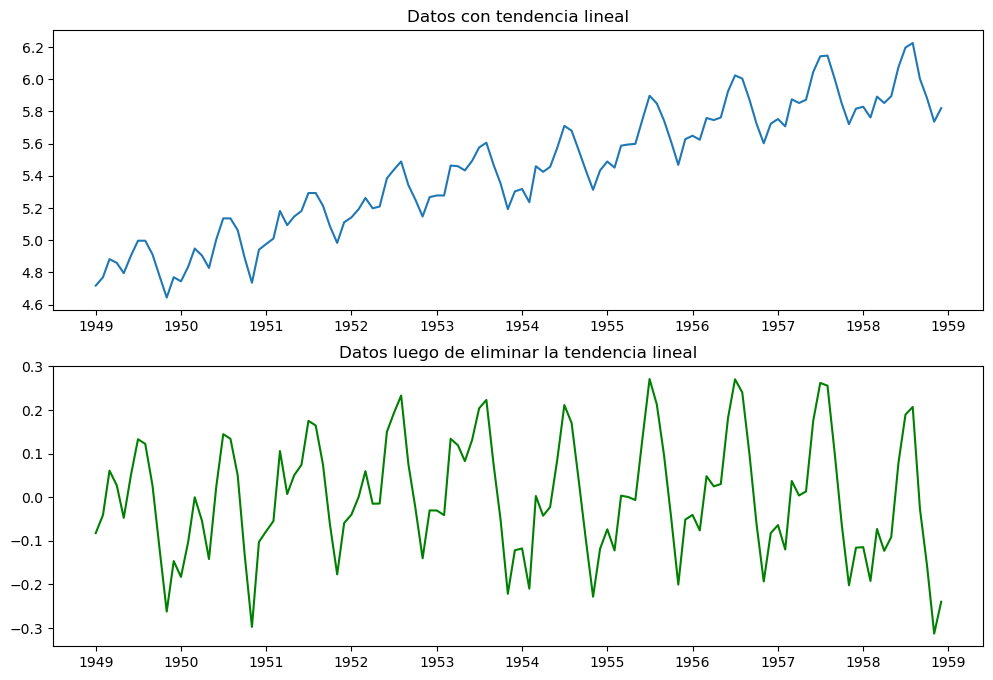

In [17]:
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.plot(df['Log Passengers'])
plt.title('Datos con tendencia lineal')
plt.subplot(2, 1, 2)
plt.plot(df['No linear Passengers'], c = 'g')
plt.title('Datos luego de eliminar la tendencia lineal')
plt.show()

### 1.1.c. Estacionalidad

Definimos la estacionalidad como la variación cíclica que se produce en los datos (https://es.wikipedia.org/wiki/Estacionalidad). En este apartado se debe encontrar y eliminar la estacionalidad. 

#### 1.1.c.a. Encontrar el periodo de la estacionalidad

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> en primer lugar debeis encontrar el ciclo, es decir, cada cuánto se repiten los datos. Para ello podemos usar la autocorrelación (numpy te permite obtener los coeficientes de correlación). Graficar los coeficientes para los 22 primeros valores de autocorrelación y determinar su valor máximo, está será nuestra estacionalidad. Dar una interpretación semántica del resultado obtenido.
</div>

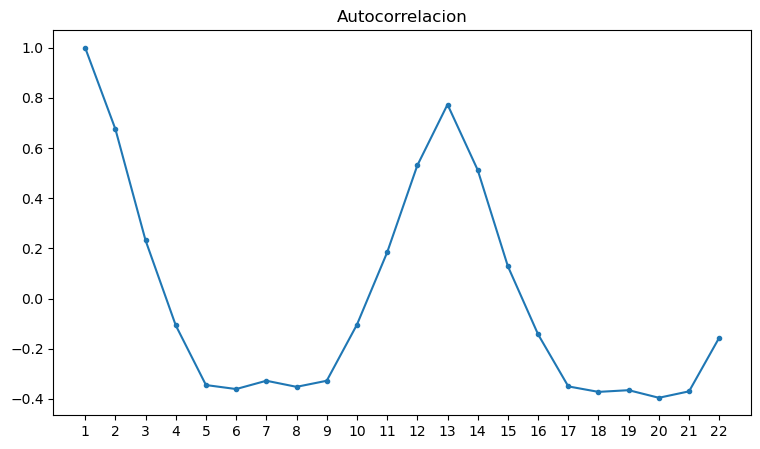

In [18]:
autocorr = np.correlate(np.array(df['No linear Passengers']), np.array(df['No linear Passengers']), mode = 'full')
autocorr = autocorr[autocorr.size // 2:][:22]
x = np.arange(1, 23, 1)
plt.figure(figsize=(9,5))

plt.plot(x,autocorr/float(autocorr.max()), marker=".")
plt.title('Autocorrelacion')
plt.xticks(x)
plt.show()

En el gráfico se muestran los coeficientes de correlación de la serie temporal consigo mismo, el funcionamiento es que para x = 1 se compara la seria consimo misma, por lo tanto es esperable tener un coeficiente de correlación = 1, a medida que vamos avanzando en el eje x se calcula el coeficiente de correlación entre la serie y ella misma pero desfasada en un mes. 
Por lo tanto: 
El primer valor da uno porque es la correlacion entre la serie consigo misma
Luego, muevo una de las series y vuelvo a hacer la correlacion consigo misma, en este caso los extremos ya no son iguales, entonces no da uno, y asi hasta el final que en este caso son 22 meses.

El grafico sirve para estimar el periodo o estacionalidad, es decir entender cada cuántos meses se repiten los datos.
En este caso es aproximadamnete cada 13 meses, es decir que la estacionalidad es anual.

#### 1.1.c.b. Calcular el patron de estacionalidad

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> ahora que ya conocéis el ciclo, debéis calcular el patrón (el molde de la estacionalidad). Es decir, para cada punto, calcular la mediana de ese punto en cada uno de los ciclos de la serie. 
</div>

In [19]:
df.head()

,Passengers,Month,Year,Day,Log Passengers,No linear Passengers
index,,,,,,
1949-01-01,112,1,1949,1,4.718499,-0.082329
1949-02-01,118,2,1949,1,4.770685,-0.040724
1949-03-01,132,3,1949,1,4.882802,0.060813
1949-04-01,129,4,1949,1,4.859812,0.027243
1949-05-01,121,5,1949,1,4.795791,-0.047359


In [20]:
# Armo un dataset con el valor de la mediana de pasajeros agrupado por mes: 
data_grouped_by_month = df[['Month','No linear Passengers']].groupby('Month').median()
data_grouped_by_month.rename(columns = {'No linear Passengers':'median_by_month'}, inplace = True)
data_grouped_by_month['Month'] = df['Month'].unique()
data_grouped_by_month.index.names = ['index']
#Patron de la serie temporal:
data_grouped_by_month

,median_by_month,Month
index,,
1,-0.075844,1
2,-0.089111,2
3,0.042705,3
4,0.002147,4
5,-0.010528,5
6,0.109443,6
7,0.198334,7
8,0.209830,8
9,0.075139,9


<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> una vez obtenido el patrón, replicadlo a lo largo de toda la serie temporal. Cuando lo hayáis calculado debéis restarlo de la serie temporal (sin tendencia ni heterocedasticidad). Graficar los datos con estacionalidad junto con los datos sin estacionalidad.
</div>

In [21]:
df = pd.merge(df, data_grouped_by_month, how='left', on = 'Month')
df.head(17)

,Passengers,Month,Year,Day,Log Passengers,No linear Passengers,median_by_month
0,112,1,1949,1,4.718499,-0.082329,-0.075844
1,118,2,1949,1,4.770685,-0.040724,-0.089111
2,132,3,1949,1,4.882802,0.060813,0.042705
3,129,4,1949,1,4.859812,0.027243,0.002147
4,121,5,1949,1,4.795791,-0.047359,-0.010528
5,135,6,1949,1,4.905275,0.051545,0.109443
6,148,7,1949,1,4.997212,0.132902,0.198334
7,148,8,1949,1,4.997212,0.122322,0.209830
8,136,9,1949,1,4.912655,0.027185,0.075139
9,119,10,1949,1,4.779123,-0.116927,-0.062405


In [22]:
df['No seasonal Passengers'] = df['No linear Passengers'] - df['median_by_month']
df.head()

,Passengers,Month,Year,Day,Log Passengers,No linear Passengers,median_by_month,No seasonal Passengers
0,112,1,1949,1,4.718499,-0.082329,-0.075844,-0.006485
1,118,2,1949,1,4.770685,-0.040724,-0.089111,0.048387
2,132,3,1949,1,4.882802,0.060813,0.042705,0.018108
3,129,4,1949,1,4.859812,0.027243,0.002147,0.025096
4,121,5,1949,1,4.795791,-0.047359,-0.010528,-0.036830


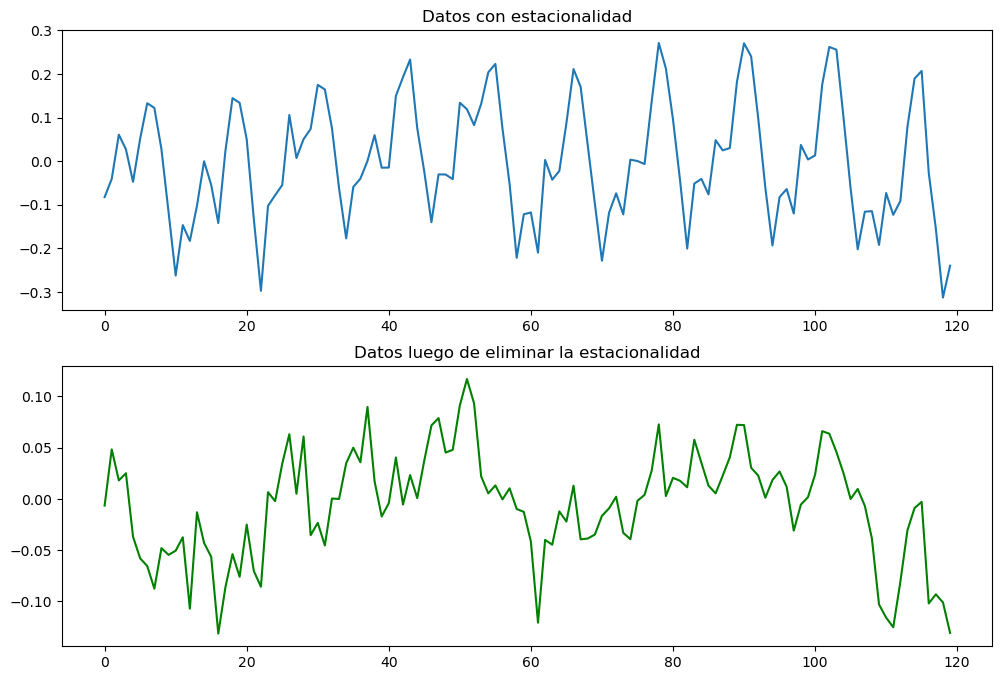

In [23]:
plt.figure(figsize=(12,8))
plt.subplot(2, 1, 1)
plt.plot(df['No linear Passengers'])
plt.title('Datos con estacionalidad')
plt.subplot(2, 1, 2)
plt.plot(df['No seasonal Passengers'], c = 'g')
plt.title('Datos luego de eliminar la estacionalidad')
plt.show()

### 1.1.d. Ruido

Una vez eliminadas la heterocedasticidad, la tendencia y la estacionalidad, lo que nos queda es el ruido. El ruido sigue una distribución normal. En este apartado debeis encontrar los parámetros de la distribución que sigue el ruido (media y desviación estandard).

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> encontrar la distribución que tiene el ruido (media y desviación estándard). Podéis usar scipy.stats. Graficar un histograma del ruido junto con un histograma de la distribución teórica que tiene el ruido.
</div>

In [24]:
#Calculo la media y el desvio estandar de la distribución normal en la serie que nos queda:
mu, std = scipy.stats.norm.fit(df['No seasonal Passengers']) 
print('Parametros de la distribuion normal del ruido: ','mean ',round(mu,4),'std ',round(std,4))

Parametros de la distribuion normal del ruido:  mean  -0.0066 std  0.0522


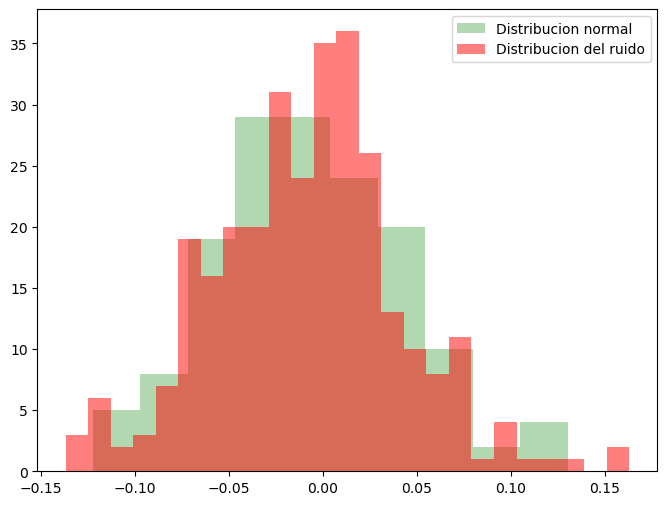

In [25]:
#histograma de una distribucion normal con los parametros encontrados: 
x = np.random.normal(loc=mu,scale=std,size=150)
plt.figure(figsize=(8,6))
plt.hist(x, color='g', alpha=0.3, label='Distribucion normal')

#histograma de la distribucion del ruido que presenta la serie:
norm_distribution = scipy.stats.norm(
    loc=mu, 
    scale=std
)
sample = norm_distribution.rvs(size=300)
plt.hist(sample, bins=25, color='r', alpha=0.5, label='Distribucion del ruido')

plt.legend()

plt.show()

## 1.2. Predicción

Vamos a predecir los dos proximos años y comparar la predicción con los datos reales. Para ello seguiremos los siguientes pasos:

   - Generar ruido
   - Añadir estacionalidad
   - Añadir tendencia
   - Añadir heterocedasticidad

### 1.2.a. Ruido

Como hemos visto que el ruido se distribuye aleatoriamente siguiendo una distribución normal, vamos a generar ruido siguiendo esta distribución.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> genera dos años de datos de ruido (24 muestras) usando la distribución encontrada en el apartado 1.1.d. Podéis usar el módulo random de numpy. Grafica los resultados.
</div>

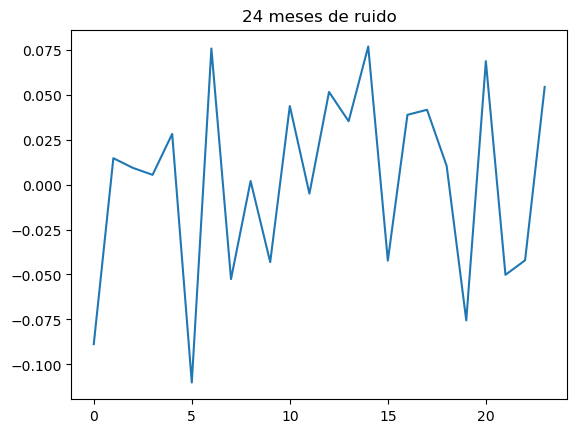

In [26]:
ruido = np.random.normal(loc=mu, scale=std, size=24)
plt.plot(ruido)
plt.title('24 meses de ruido')
plt.show()

### 1.2.b. Estacionalidad

Anteriormente hemos calculado la estacionalidad y el ciclo de la serie temporal. Vamos a usar esta estacionalidad ya calculada para añadirla a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los dos años de ruido calculados en el apartado anterior los dos años de estacionalidad encontrada en el apartado 1.1.c. Grafica los resultados.
</div>

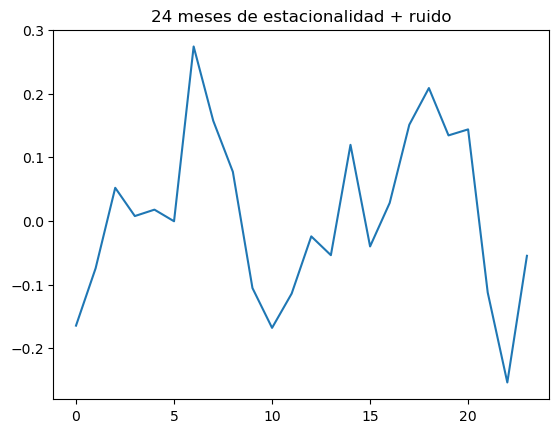

In [27]:
ruido_estacionalidad = ruido + df[:24]['median_by_month']
plt.plot(ruido_estacionalidad)
plt.title('24 meses de estacionalidad + ruido')
plt.show()

### 1.2.c. Tendencia

Anteriormente hemos visto que los datos de la serie temporal tienen una tendencia lineal y la hemos calculado mediante una regresión lineal. Vamos a añadir esta tendencia a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los dos años de ruido + estacionalidad calculados en el apartado anterior la tendencia encontrada en el apartado 1.1.b. Grafica los resultados.
</div>

In [28]:
#Calculo la tendencia lineal para los ultimos 24 meses: 
data['Log Passengers'] = np.log(data['Passengers'])
X = np.array(range(len(data['Log Passengers'])))
reg2 = LinearRegression().fit(X.reshape(-1,1), data['Log Passengers'])
pred_lin2 = reg2.predict(X.reshape(-1,1))

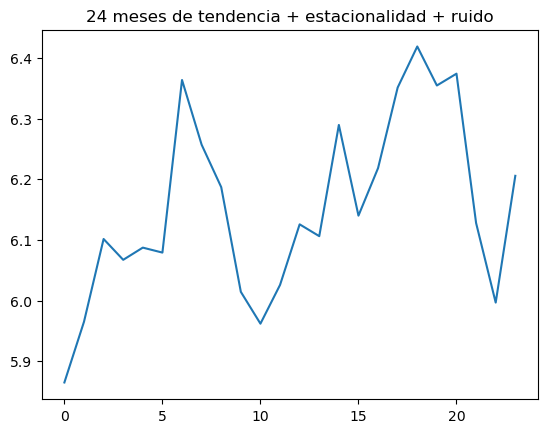

In [29]:
ruido_estacionalidad_tendencia = ruido_estacionalidad + pred_lin2[-24:]
plt.plot(ruido_estacionalidad_tendencia)
plt.title('24 meses de tendencia + estacionalidad + ruido')
plt.show()

### 1.2.d. Heterocedasticidad

En el primer apartado de esta práctica hemos visto que la serie temporal tiene heterocedasticidad y la hemos eliminado transformando los datos. En este apartado haremos la transfromación inversa para añadir heterocedasticidad a nuestra predicción.

<div class="alert alert-block alert-info">
    <strong>Implementación:</strong> añade a los dos años de ruido + estacionalidad + tendencia calculados en el apartado anterior la heterocedasticidad aplicando la función inversa a la encontrada en el apartado 1.1.a. Grafica el resultado junto con la serie completa y compara la predicción obtenida con los datos reales.
</div>

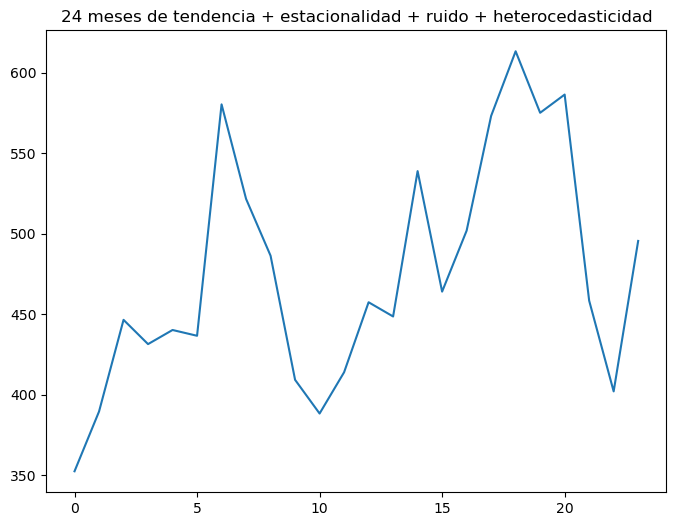

In [30]:
ruido_estacionalidad_tendencia_heteroced = np.exp(ruido_estacionalidad_tendencia)
plt.figure(figsize=(8,6))
plt.plot(ruido_estacionalidad_tendencia_heteroced)
plt.title('24 meses de tendencia + estacionalidad + ruido + heterocedasticidad')
plt.show()

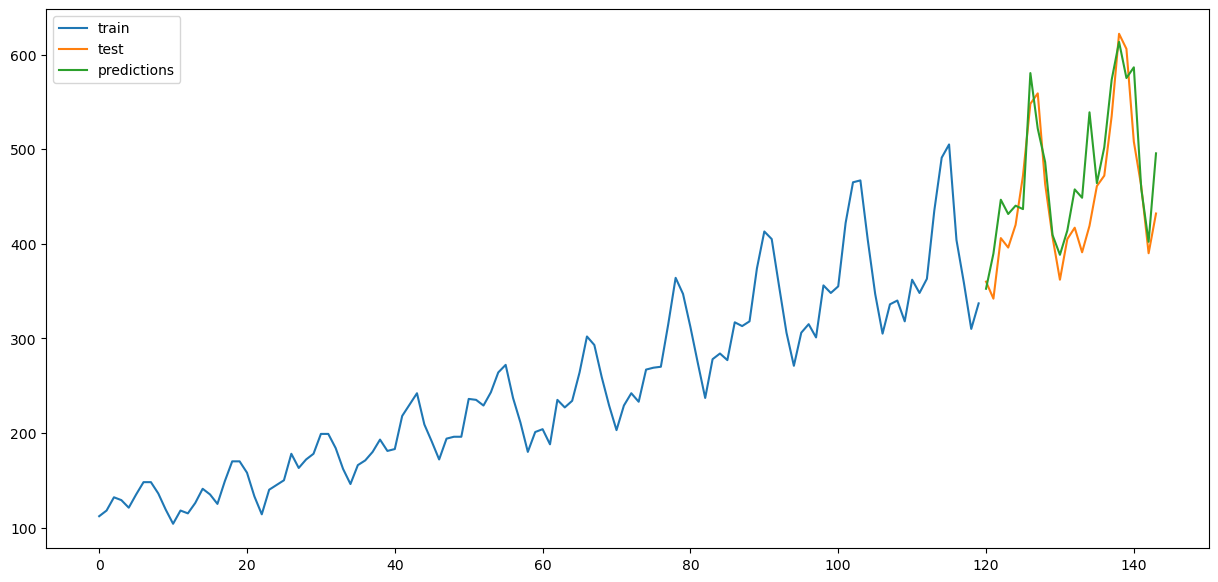

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(x_train, train,label='train')
ax.plot(x_test,test,label='test')
ax.plot(x_test, ruido_estacionalidad_tendencia_heteroced, label='predictions')
plt.legend()
plt.show()

<div class="alert alert-block alert-info">
    <strong>[Bonus] Implementación:</strong> como la distribución del ruido generado es aleatoria, en cada ejecución obtendremos predicciones distintas. Una manera de asegurar que la predicción obtenida es fiable es generando intervalos de confianza. 
    <hr>
Para ello vamos a repetir los pasos anteriores pero generando 500 muestras de dos años de longitud cada una (o sea 500 predicciones). Una vez generadas definimos:
    
   - Intervalo de confianza = (min(predicciones), max(predicciones))
   - Predicción final = median(predicciones)
   
Graficar:

   - La serie temporal entera
   - Los dos años de predicción (mediana de las 500 muestras de predicción)
   - El valor real de los dos años que hemos predicho 
   - Los intérvalos de confianza (min y max de las 500 muestras de predicción) 

Para graficar los intérvalos de confianza podéis usar fill_between de matplotlib.
</div>

In [32]:
#Generamos las 500 muestras
predicciones = []

for i in range(0,500):
    ruido = np.random.normal(loc=mu, scale=std, size=24)
    ruido_estacionalidad = ruido + df[:24]['median_by_month']
    ruido_estacionalidad_tendencia = ruido_estacionalidad + pred_lin2[-24:]
    ruido_estacionalidad_tendencia_heteroced = np.exp(ruido_estacionalidad_tendencia)
    predicciones.append(ruido_estacionalidad_tendencia_heteroced)

In [33]:
predicciones_aux = []
min_prediccion = [] 
max_prediccion = [] 
median_prediccion = [] 

for i in range(0,24):
    predicciones_aux = []
    for j in range(0,500):
        predicciones_aux.append(predicciones[j][i])
    min_prediccion.append(min(predicciones_aux))
    max_prediccion.append(max(predicciones_aux))
    median_prediccion.append(np.median(predicciones_aux))

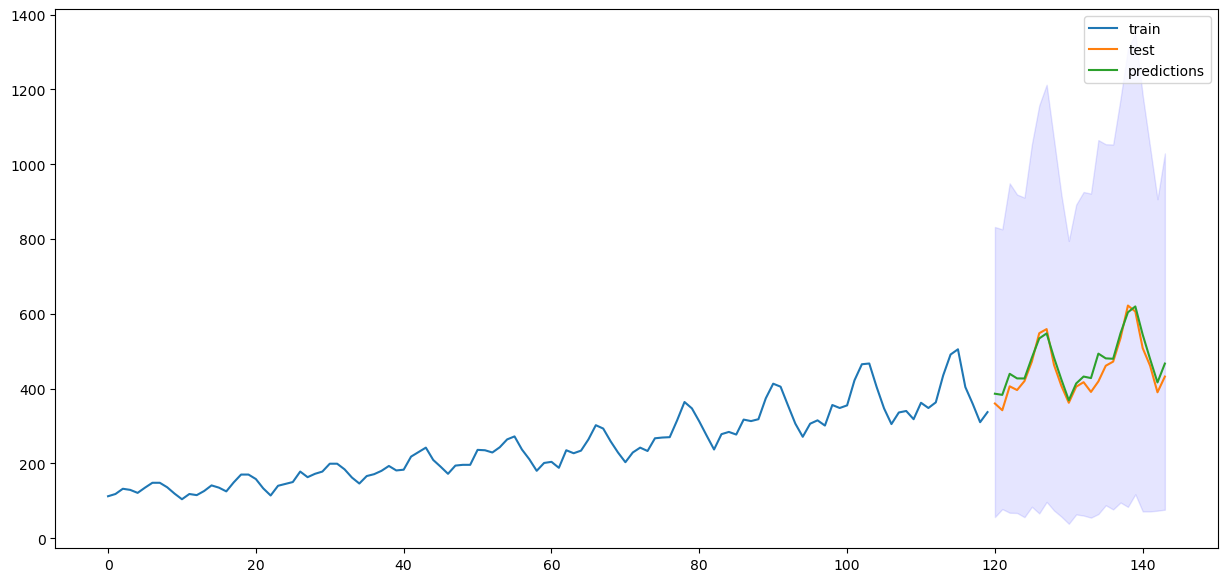

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(15, 7))
ax.plot(x_train, train, label='train')
ax.plot(x_test,test, label='test')
ax.plot(x_test, median_prediccion, label='predictions')
ax.fill_between(x_test, [x - y for x, y in zip(median_prediccion, min_prediccion)], [x + y for x, y in zip(median_prediccion, max_prediccion)], color='b', alpha=.1)
plt.legend()
plt.show()

### 2. Combinación de clasificadores

En este ejercicio utilizaremos un subconjunto de 5.000 imágenes provenientes del corpus EMNIST, constituido por carácteres y dígitos escritos a mano
. Dicho subconjunto está formado por 1.000 imágenes para cada una de las 5 clases diferentes ("A", "B", "C", "D" y "E").

La primera parte de este ejercicio abordará la combinación de clasificadores en paralelo mediante las tecnicas de **_Bagging_** y **_Boosting_**.

Mientras que la segunda parte pretende mejorar los resultados aplicando tecnicas de combinación secuencial de clasificadores: **_Stacking_** y **_Cascading_**.

Para empezar, vamos a visualizar el dataset. Las imágenes tienen una resolución de 28x28 píxeles en escala de grises, por lo que se pueden representar utilizando un vector de 784 posiciones. El siguiente código cargará las 5.000 imágenes en la variable images y las correspondientes etiquetas (en forma numérica) en la variable labels. Podemos comprobar que la carga ha sido correcta obteniendo las dimensiones de estas dos variables.

In [35]:
with open("data.pickle", "rb") as f:
    data = pickle.load(f)
    
images = data["images"]
labels = data["labels"]
n_classes = 5
labels_text = ["A", "B", "C", "D", "E"]

print("Dimensiones del vector de imágenes: {}".format(images.shape))
print("Dimensiones del vector de etiquetas: {}".format(labels.shape))

Dimensiones del vector de imágenes: (5000, 784)
Dimensiones del vector de etiquetas: (5000,)


Con el siguiente código podemos ver un ejemplo de imagen de cada una de las clases. Para ello reajustamos el vector de 784 dimensiones que representa cada imagen en una matriz de tamaño 28x28 y la transponemos para mostrarla:

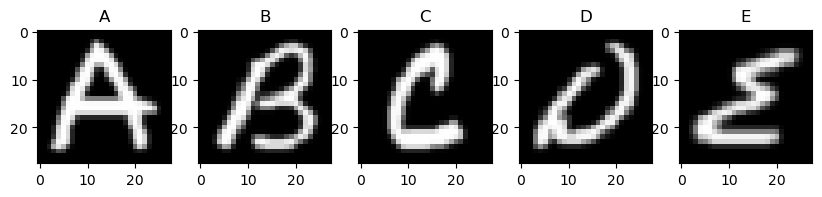

In [36]:
fig, ax = plt.subplots(1, n_classes, figsize=(10,10))

idxs = [np.where(labels == i)[0] for i in range(n_classes)]

for i in range(n_classes):
    k = np.random.choice(idxs[i])
    ax[i].imshow(images[k].reshape(28, 28).transpose(), cmap="gray")
    ax[i].set_title("{}".format(labels_text[i]))

Para poder probar varios modelos, primero vamos a dividir el dataset en train y test.

La división con la función *train_test_split* es aleatoria , pero para que todos obtengáis los mismos resultados y poder comentar dudas por el foro, fijaremos la seed para obtener los mismos datasets de train y test. El *split* tendrá en cuenta que los dos conjuntos tengan el mismo número de ejemplos para cada una de las clases gracias al parámetro *stratify=labels*.

Como en la segunda parte de este ejercicio trataremos *stacking* y *cascading*, y ambos se aplican sobre el conjunto de test, haremos un *split* del 50% para tener un poco más de base al aplicar estas dos técnicas.

In [37]:
myseed = 13

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.5,
                                                    random_state=myseed, 
                                                    stratify=labels)

### 2.1. Combinación paralela de clasificadores

#### 2.1.1. Árbol de decisión

Para poder comparar el aumento de *performance* obtenido a medida que aplicamos técnicas nuevas, utilizaremos como *baseline* un simple árbol de decisión.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Evalúa la precisión de un árbol de decisión con profundidad máxima de 5 niveles (aplicaremos la misma restricción en las siguientes secciones) aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
       
<u>Sugerencia</u>: usar el módulo *cross_val_score* de *sklearn*. Para aprender más sobre *cross validation* y sobre cómo usar estos módulos, os recomendamos los siguientes enlaces: 
- http://scikit-learn.org/stable/modules/cross_validation.html
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
</div>

In [38]:
clf = DecisionTreeClassifier(max_depth=5)
#Accuracy sobre el set train
score_train_clf = cross_val_score(clf, X_train, y_train, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Train:', round(score_train_clf.mean(),4))

Accuracy sobre conjunto de Train: 0.7964


In [39]:
#Entreno el modelo con el set de entrenamiento: 
clf.fit(X_train, y_train)
# Predicciones sobre el set de test
y_test_pred_clf = clf.predict(X_test)
#Accuracy sobre el set test
score_test_clf = cross_val_score(clf, X_test, y_test, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Test:', round(score_test_clf.mean(),4))

Accuracy sobre conjunto de Test: 0.8052


#### 2.1.2. *Bagging*

#### 2.1.2.a. Random Forest

La idea básica del bagging es utilizar el conjunto de entrenamiento original para generar centenares o miles de conjuntos similares usando muestreo con reemplazo. En este concepto está basado el algoritmo Random Forest, la combinación de varios árboles de decisión, cada uno entrenado con una realización diferente de los datos. La decisión final del clasificador combinado (el Random Forest) se toma por mayoría, dando el mismo peso a todas las decisiones parciales tomadas por los clasificadores base (los árboles).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
        
Evalúa la precisión de un <i>random forest</i> combinando 20 árboles de decisión con profundidad máxima de 5 niveles aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
    
<u>Sugerencia</u>: usar el módulo *RandomForestClassifier* de *sklearn*. Para aprender a usar este módulo os recomendamos el siguiente enlace:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
</div>

In [40]:
random_forest = RandomForestClassifier(max_depth=5, n_estimators=20)
#Accuracy sobre el set train
score_train_random_forest = cross_val_score(random_forest, X_train, y_train, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Train:', round(score_train_random_forest.mean(),4))

Accuracy sobre conjunto de Train: 0.888


In [41]:
#Entreno el modelo con el set de entrenamiento: 
random_forest.fit(X_train, y_train)
# Predicciones sobre el set de test 
y_test_pred_random_forest = random_forest.predict(X_test)
#Accuracy sobre el set test
score_test_random_forest = cross_val_score(random_forest, X_test, y_test, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Test:', round(score_test_random_forest.mean(),4))

Accuracy sobre conjunto de Test: 0.8852


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿han mejorado los resultados respecto a un simple árbol de decisión? ¿Era de esperar?
</div>

Si, ha habido una mejora en la precisión tanto del conjunto de train como el de test. Esto era de esperarse debido a que la idea del bagging es partir de muchos clasificadores base no muy precisos y luego minimizar los errores cometidos por cada uno de ellos a través de la votación de la mayoría: la clase resultante del clasificador random_forest será la que aparece más veces entre las decisiones que toma cada árbol por separado, en este caso se utilizaron 20 árboles de profundidad máxima 5, cada uno de los cuales por separado tuvo una clasificación y luego el modelo final seleccionó la clase mayoritaria entre los 20 árboles. 

#### 2.1.2.b. Out-of-bag

Una ventaja del *bagging* usado en el *Random Forest* es que cada uno de los árboles de decisión ha sido entrenado con una combinación diferente de los datos (muestreo con reemplazo), es decir, cada uno de los árboles no ha visto una determinada parte de los datos originales. Esto define una especie de conjunto de test para cada uno de los árboles, llamado *out-of-bag*, que puede ser usado para estimar el error del modelo sin necesidad de usar el conjunto de test real que creamos previamente, ni de usar estrategias de *cross-validation*.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
      
Entrena sobre el conjunto de train un modelo de <i>random forest</i>combinando 20 árboles de decisión con profundidad máxima de 5 niveles y muestra la precisión de este modelo en el *out-of-bag*.
    
<u>Sugerencia</u>: usar el módulo *RandomForestClassifier* de *sklearn*. Para aprender más sobre *out-of-bag* y sobre como usar este módulo (incluyendo el atributo *oob&#95;score_*), os recomendamos los siguientes enlaces:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
- http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html

</div>

In [42]:
random_forest = RandomForestClassifier(max_depth=5, n_estimators=20, oob_score=True)
random_forest.fit(X_train, y_train)
print('Out of bag:', random_forest.oob_score_)

Out of bag: 0.858


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿la precisión obtenida en el <i>out-of-bag</i> y con los métodos de validación anteriores son comparables? ¿Era de esperar? 
</div>

La precisión obtenida con el out-of-bag y con el método de cross-validation son comparables, aproximadamente 0,8 en ambos casos. 
Era de esperarse que den similares ya que en los modelos de Random Forest no es necesario aplicar validación cruzada o un conjunto de test separado para obtener una estimación imparcial del error del set de testeo, sino que esto lo hace internamente por la característica del muestreo con reemplazo: cada clasificador del Random Forest se genera con un subconjunto aleatoria de las variables del conjunto de datos. 

- Out of bag: permite calcular el promedio entre los errores cometidos por cada clasificador del random forest cuando intentan clasificar aquellos elementos que no formaron parte del conjunto de entrenamiento usado para construirlos. 
- K Fold Cross Validation divide de forma aleatoria el conjunto de datos en k grupos y usa k-1 para entrenar al modelo y el grupo de datos que quedo fuera lo usa para testearlo, esto lo repite K veces para ir variando el conjunto de entrenamiento y de testeo. 


#### 2.1.2.c. Número de clasificadores agregados

En los ejercicios anteriores hemos combinado 20 clasificadores simples en nuestro clasificador combinado. ¿Será que la precisión del clasificador combinado aumenta indefinidamente su desempeño si añadimos más clasificadores?

Para responder a esta pregunta vamos a representar una curva de validación. La curva de validación es una representación gráfica del desempeño de un modelo variando uno de sus parámetros. Esto nos permite entender cuál es el impacto de un determinado parámetro en el desempeño de un modelo.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>    
    
Entrena varios modelos de <it>Random Forest</it> con un número de árboles cada vez mayor. Para cada modelo, calcula su precisón en el conjunto de test o usando *cross-validation* en el conjunto de entrenamiento. Opcional: representa gráficamente la evolución de la precisión con el número de árboles para ayudarte en el análisis de los resultados.
<br><br>
    
<u>Sugerencia</u>: usar el módulo *validation_curve* de sklearn. Para aprender a usar este módulo os recomendamos los siguientes enlaces:<br>
- http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html<br>
- http://scikit-learn.org/stable/modules/learning_curve.html#validation-curve
</div>

In [43]:
param_range = np.arange(10,610,20)
train_score, test_score = validation_curve(RandomForestClassifier(max_depth=5),
                                           X_train,
                                           y_train,
                                           param_name = "n_estimators",
                                           param_range = param_range,
                                            cv = 5,
                                           scoring = "accuracy")

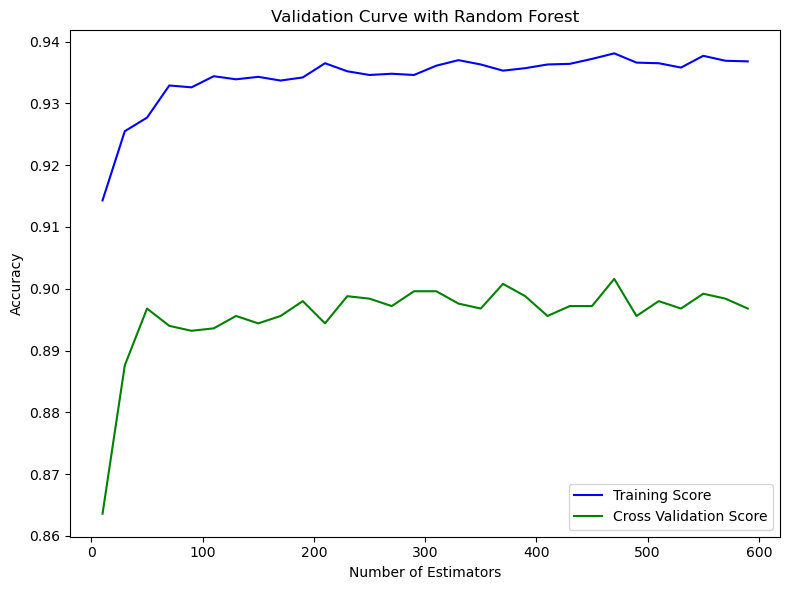

In [44]:
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.figure(figsize=(8,6))
plt.plot(param_range, mean_train_score,
     label = "Training Score", color = 'b')
plt.plot(param_range, mean_test_score,
   label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with Random Forest")
plt.xlabel("Number of Estimators")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿incrementa indefinidamente la precisión con el número de árboles combinados o se satura en una precisión límite? ¿Por qué?
</div>

La precisión no incrementa de forma indefinida al ir aumentando los estimadores del modelo, sino que a partir de una cantidad de árboles determinada, aproximadamente 100 clasificadores, el modelo no mejora la precisión, sino que permanece en el mismo rango, o se satura. Esto indica que para mejorar la precisión ya no es suficiente con incrementar la cantidad de clasificadores sino que habría que probar con otro modelo porque para este caso este es su límite para clasificar estas clases.

#### 2.1.3. *Boosting*

En el sistema de Boosting se combinan varios clasificadores débiles sequencialmente, y en cada uno de ellos se da más peso a los datos que han sido erróneamente clasificados en las combinaciones anteriores, para que se concentre así en los casos más difíciles de resolver.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>

Evalúa la precisión de un <i>gradient boosting</i> con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i> aplicando validación cruzada sobre el conjunto de datos de train.
    
A continuación, entrena el mismo modelo sobre el conjunto de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test.
    
<u>Sugerencia</u>: usar el módulo *GradientBoostingClassifier* de sklearn. Para aprender a usar este módulo os recomendamos el siguiente enlace:
- http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html
</div>

In [45]:
xgb = GradientBoostingClassifier(n_estimators=20, max_depth=5)
#Accuracy sobre el set train
score_train_xgb = cross_val_score(xgb, X_train, y_train, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Train:', round(score_train_xgb.mean(),4))

Accuracy sobre conjunto de Train: 0.9204


In [46]:
#Entreno el modelo con el set de entrenamiento: 
xgb.fit(X_train, y_train)
# Predicciones sobre el set de test
y_test_pred_xgb = xgb.predict(X_test)
#Accuracy sobre el set test
score_test_xgb = cross_val_score(xgb, X_test, y_test, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Test:', round(score_test_xgb.mean(),4))

Accuracy sobre conjunto de Test: 0.9184


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> ¿han mejorado los resultados respecto a un simple árbol de decisión? ¿Era de esperar?
</div>

Si, los resultados han mejorado y era de esperarse ya que el método Boosting es un poco diferente al método Bagging. 
En este caso también se parte de clasificadores de base sencillos pero en vez de que todos los clasificadores trabajen de forma paralela y luego se someta el resultado a votación, en este caso los clasificadores trabajan en serie y los datos de entrenamiento están ponderados según los errores que cometió el clasificador anterior de forma de que cada uno se enfoque en los elementos más dificiles de clasificar, cada etapa o clasificador intenta corregir los errores de la etapa anterior, sin modificar las decisiones correctas. 

### 2.2. Combinación secuencial de clasificadores base diferentes

Para poder hacer combinación secuencial de modelos, necessitamos tener varios modelos diferentes entrenados. 

En nuestro caso, ya tenemos un árbol de decisión, el *random forest* y el *gradient boosting*. Vamos a entrenar un par de modelos más.

#### 2.2.1 Clasificadores adicionales

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Implementación:</strong>
<br><br>
    
Entrena un <i>k-neighbors</i> con 2 vecinos sobre el conjunto de datos de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test. 

Entrena un SVM (Suport vector machines) con gamma = 0.07 sobre el conjunto de datos de train, calcula y guarda las predicciones sobre el conjunto de test y calcula la precisión en el conjunto de test. 
</div>  

In [47]:
import warnings
warnings.filterwarnings('ignore')
knn = KNeighborsClassifier(n_neighbors=2)
#Accuracy sobre el set train
score_train_knn = cross_val_score(knn, X_train, y_train, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Train:', round(score_train_knn.mean(),4))

Accuracy sobre conjunto de Train: 0.9172


In [48]:
#Entreno el modelo con el set de entrenamiento: 
knn.fit(X_train, y_train)
# Predicciones sobre el set de test
y_test_pred_knn = knn.predict(X_test)
#Accuracy sobre el set test
score_test_knn = cross_val_score(knn, X_test, y_test, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Test:', round(score_test_knn.mean(),4))

Accuracy sobre conjunto de Test: 0.9192


In [49]:
svm = SVC(gamma=0.07)
#Accuracy sobre el set train
score_train_svm = cross_val_score(svm, X_train, y_train, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Train:', round(score_train_svm.mean(),4))

Accuracy sobre conjunto de Train: 0.2


In [50]:
#Entreno el modelo con el set de entrenamiento: 
svm.fit(X_train, y_train)
# Predicciones sobre el set de test  
y_test_pred_svm = svm.predict(X_test)
#Accuracy sobre el set test
score_test_svm = cross_val_score(svm, X_test, y_test, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Test:', round(score_test_svm.mean(),4))

Accuracy sobre conjunto de Test: 0.2


In [51]:
set(y_test_pred_svm)

{4}

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Análisis:</strong> comenta los resultados.
</div>

Podemos ver que la precisión que obtuvimos con el modelo KNN con dos vecinos para clasificar cada elemento, es de 0.9 similar a la obtenida con el modelo de boosting.
Por otro lado, con el modelo SVM la precisión fue muy baja, de 0.2, predijo la misma clase para todas las instancias, lo cual puede estar relacionado al valor del hiperparametro gamma, que es el coeficiente que multiplica la distancia entre dos puntos en el kernel radial, cuanto más pequeño es, más influencia tienen dos puntos cercanos. Una posibilidad para mejorar este modelo podría ser probar con distintos valores para gamma. 

### 2.2.2 *Stacking*

Un clasificador de *stacking* usa como atributos las predicciones hechas por otros clasificadores en lugar de los datos originales de entrada.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
<br><br>
    
Construye un clasificador de <i>stacking</i> usando un <i>Gradient Boosting</i> (con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i>) que use como atributos las predicciones hechas en el conjunto de test por los algoritmos: 
    
- árbol de decisión
- random forest
- gradient boosting
- knn
- svm 
 
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test (en este caso no tenemos conjunto de train, con lo cual se hace directamente cross-validation sobre test).

<u>Sugerencia</u>: usar la función column_stack de numpy para juntar todas las predicciones. Dado que las variables que usaremos ahora como predictors son categóricas, es preferible transformarlas en *dummies* (*one-hot-encoding*). Para apender a usar estas funciones os recomendamos los siguientes enlaces:
- https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.column_stack.html
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
</div>

In [52]:
enc = OneHotEncoder(handle_unknown = 'ignore')
enc_y_test_pred_clf = enc.fit_transform((y_test_pred_clf).reshape(-1, 1)).toarray()
enc_y_test_pred_random_forest = enc.fit_transform((y_test_pred_random_forest).reshape(-1, 1)).toarray()
enc_y_test_pred_xgb = enc.fit_transform((y_test_pred_xgb).reshape(-1, 1)).toarray()
enc_y_test_pred_knn = enc.fit_transform((y_test_pred_knn).reshape(-1, 1)).toarray()
enc_y_test_pred_svm = enc.fit_transform((y_test_pred_svm).reshape(-1, 1)).toarray()
enc_y_test = enc.fit_transform((y_test).reshape(-1, 1)).toarray()

In [53]:
enc_y_test_pred_random_forest[0:3]

array([[0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [54]:
enc_y_test_pred_clf[0:3]

array([[0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0.]])

In [55]:
#Como la prediccion del modelo SVM es siempre 4, el One Hot Encoder lo dejó igual, siempre 1:
enc_y_test_pred_svm

array([[1.],
       [1.],
       [1.],
       ...,
       [1.],
       [1.],
       [1.]])

In [56]:
#La clase 4 corresponde a este array dummy:
enc_y_test_pred_random_forest[7]

array([0., 0., 0., 0., 1.])

In [57]:
#Convierto los 1 del resultado del SVM en el valor 4 dummy:
enc_y_test_pred_svm = np.full((2500, 5), [0., 0., 0., 0., 1.])
enc_y_test_pred_svm[0]

array([0., 0., 0., 0., 1.])

In [58]:
stack_pred = []
for i in range(len(enc_y_test_pred_clf)):
    aux = np.column_stack((enc_y_test_pred_clf[i].T, enc_y_test_pred_random_forest[i].T,
                          enc_y_test_pred_xgb[i].T,enc_y_test_pred_knn[i].T,
                          enc_y_test_pred_svm[i].T)).T.tolist()
    stack_pred.append(aux)

In [59]:
stack_pred = np.asarray(stack_pred, dtype = 'int')
stack_pred[0]

array([[0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 0, 0, 1]])

In [60]:
nsamples, nx, ny = stack_pred.shape
d2_stack_pred = stack_pred.reshape((nsamples,nx*ny))
d2_stack_pred[0]

array([0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1])

In [61]:
xgb = GradientBoostingClassifier(n_estimators=20, max_depth=5)
#Entreno el modelo con el set de entrenamiento: 
xgb.fit(d2_stack_pred, y_test)

GradientBoostingClassifier(max_depth=5, n_estimators=20)

In [62]:
#Accuracy sobre el set test
score_stack_xgb = cross_val_score(xgb, d2_stack_pred, y_test, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Test:', round(score_stack_xgb.mean(),4))

Accuracy sobre conjunto de Test: 0.9308


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis:</strong> ¿has conseguido mejorar la precisión gracias al <i>stacking</i>? Comenta los resultados.
</div>

Si, la precisión del modelo con el método stacking fue más alta que la precisión de cada clasificador por separado. Esto era de esperarse ya que el clasificador, en este caso el XGB, se entrena con las predicciones obtenidas de los otros cinco clasificadores base, logrando mejorar la capacidad predictiva del modelo.

### 2.2.3. *Cascading*

El caso de *cascading* es parecido al de *stacking* pero utilizando no solamente las predicciones parciales de los clasificadores base, sino también los datos originales.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Implementación:</strong>
<br><br>
    
Construye un clasificador de <i>cascading</i> usando un <i>Gradient Boosting</i> (con profundidad máxima de 5 niveles y 20 etapas de <i>boosting</i>) que use como atributos las predicciones obtenidas con los modelos anteriores en el conjunto de test (igual que con el <i>stacking</i>), y también las variables originales. 
    
Calcula la precisión del modelo resultante con *cross-validation* en el conjunto de test.

<u>Sugerencia</u>: Usa el mismo conjunto de datos que en el ejercicio anterior pero añade `X_test`.
</div>

In [64]:
cascading_pred = np.column_stack((d2_stack_pred, X_test))

In [65]:
xgb = GradientBoostingClassifier(n_estimators=20, max_depth=5)
#Entreno el modelo con el set de entrenamiento: 
xgb.fit(cascading_pred, y_test)

GradientBoostingClassifier(max_depth=5, n_estimators=20)

In [66]:
#Accuracy sobre el set test
score_cascading_xgb = cross_val_score(xgb, cascading_pred, y_test, scoring = 'accuracy', cv = 5)
print('Accuracy sobre conjunto de Test:', round(score_cascading_xgb.mean(),4))

Accuracy sobre conjunto de Test: 0.938


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Análisis:</strong> ¿has conseguido mejorar la precisión gracias al <i>cascading</i>? Comenta los resultados.
</div>

Si, el resultado del modelo aplicado al conjunto de test ha dado un accuracy de 0.94. Es el valor más alto conseguido. La mejora que aplica el método cascading al método stacking es que además de entrenarse con las predicciones de los clasificadores base, se alimenta de los datos originales, esto hace que no base únicamente su decisión en los resultados de los clasificadores base sino que pueda también considerar estas otras variables, lo cual en este caso, ha mejorado el resultado.
Los distintos scores obtenidos con los modelos los podemos ver en el siguiente grafico:

In [67]:
scores_test=[score_test_clf.mean(), score_test_random_forest.mean(), score_test_xgb.mean(), score_test_knn.mean(), score_test_svm.mean(), score_stack_xgb.mean(), score_cascading_xgb.mean()]
scores_train=[score_train_clf.mean(), score_train_random_forest.mean(), score_train_xgb.mean(), score_train_knn.mean(), score_train_svm.mean()]
modelos_train=['Decision Tree', 'Random Forest', 'XGBoost','K Nearest neighbor', 'Support Vector Machine']
modelos_test=['Decision Tree', 'Random Forest', 'XGBoost','K Nearest neighbor', 'Support Vector Machine','Stacking','Cascading']

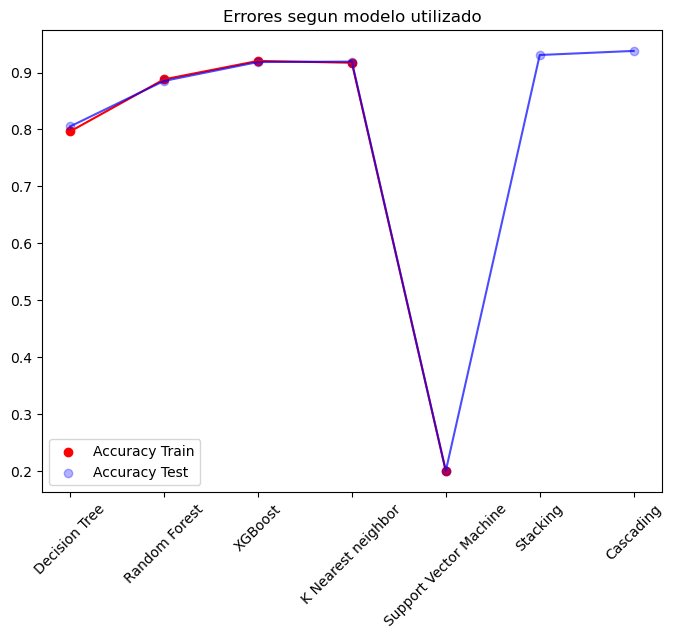

In [68]:
plt.figure( figsize = (8,6))
plt.scatter(x = modelos_train, y = scores_train, color = 'red', label='Accuracy Train')
plt.scatter(x = modelos_test, y = scores_test, color = 'blue', alpha=0.3,label='Accuracy Test')
plt.plot(scores_train, color = 'red')
plt.plot(scores_test, color = 'blue', alpha=0.7)

plt.legend()
plt.xticks(rotation = 45)
plt.title('Errores segun modelo utilizado')
plt.show()